# Código para generar una gráfica de potencia relativa suavizada

### Cargar bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
%config InlineBackend.figure_format = 'svg'

### Funciones a utilizar

In [98]:
def carga_archivo_excel(nombre_archivo):
    """
    Esta función carga un archivo excel a un dataframe de pandas. 
    -nombre_archivo (str): el nombre del archivo (entre comillas) con extensión .xlsx (sin espacios es mejor).
    """
    return pd.read_excel(nombre_archivo)
    
def preprocesamiento_datos(datos, nombre_frecuencia, nombres_columnas, inicio_filas=0, fin_filas=500):
    """
    Esta función utiliza los datos cargados desde un archivo excel y guarda la columna de promedios, 
    errores y frecuencias. 
    
    *Entradas:
    -datos (Dataframe): Dataframe con los datos.
    -nombre_frecuencia(str): el nombre de la columna de frecuencia.
    -nombres_columnas (list, str): lista de strings con los nombres de las columnas del dataframe que se quieren incluir. 
                    El formato debe ser el siguiente: 
                    ["columna_promedio1","columna_error1","columna_promedio2","columna_error2"]...
    -inicio_filas (int): el índice donde empiezan las filas que se quieren incluir. 
    -fin_filas (int): el índice donde acaban las filas que se quieren incluir. El default es 500 para una resolución de 
                    frecuencia que va desde 0 hasta 50 en pasos de 0.1. 
    
    *Salidas:
    frecuencias: array con las frecuencias. 
    promedios, errores: listas de arrays con los promedios y los errores. 
    """
    
    frecuencias = np.asarray(datos[nombre_frecuencia])[inicio_filas:fin_filas]
    promedios = []
    errores = []
    
    for i in range(0,len(nombres_columnas),2):
        promedios.append(np.asarray(datos[nombres_columnas[i]])[inicio_filas:fin_filas])
        
    for j in range(1,len(nombres_columnas),2):
        errores.append(np.asarray(datos[nombres_columnas[j]])[inicio_filas:fin_filas])
    
    return frecuencias, promedios, errores

def suavizado_datos_savgol(promedios_potencia, errores, ventana_promedios=25, orden_polinomio_promedios=2, 
                           ventana_errores=25, orden_polinomio_errores=2):
    """
    Función para suavizar los datos usando el filtro de Savitzky-Golay.  
    
    *Entradas:
    promedios_potencia: la lista de promedios de la potencia relativa.
    errores: la lista de los errores para cada grupo. 
    ventana: tamaño de la ventana en la que el filtro va a ajustar. Mientras mayor la ventana, mayor el suavizado y 
            menor la resolución. El default es 25. 
    orden_polinomio: el orden del poliniomio en el que filtro va a ajustar. Mientras mayor el orden, más preciso el 
                    ajuste de datos, lo que puede llevar a overfitting. 
                    
    *Salidas:
    promedios_suavizados, errores_suavizados: listas de arrays con los promedios suavizados y los errores suavizados.
    """
    promedios_suavizados = []
    errores_suavizados = []
    
    if len(promedios_potencia)==len(errores):
        for i in range(len(promedios_potencia)):
            promedios_suavizados.append(savgol_filter(promedios_potencia[i],ventana_promedios,orden_polinomio_promedios))
            errores_suavizados.append(savgol_filter(errores[i],ventana_errores,orden_polinomio_errores))
    else:
        for i in range(len(promedios_potencia)):
            promedios_suavizados.append(savgol_filter(promedios_potencia[i],ventana_promedios,orden_polinomio_promedios))
        for j in range(len(errores)):
            errores_suavizados.append(savgol_filter(errores[i],ventana_errores,orden_polinomio_errores))
    
    return promedios_suavizados, errores_suavizados

def factor_error(opcion, errores, errores_suavizados):
    """
    Función para obtener el factor por el que se quiere multiplicar el error para graficarlo. 
    opcion: float de 1 a 4. 
    Opciones para el factor de error: 
    1. Darle un valor arbitrario (normalmente, por como están los datos, entre 0 y 1)
    2. Multiplicar por la media del error original del dataframe: np.mean
    3. Multiplicar por la desviación estándar del error original del dataframe: np.std (es la que estaba por default). 
    4. La función automáticamente multiplica el error_suavizado por 1 (el error graficado es el mismo, el suavizado).
    """

    factor = []
    
    if opcion==1:
        x = float(input("Introduce un número de 0 a 1 para el factor: "))
        for i in range(len(errores)):
            factor.append(errores_suavizados[i]*x)
    
    elif opcion==2:
        for i in range(len(errores)):
            factor.append(errores_suavizados[i]*np.mean(errores[i]))
            print("La media es:",np.mean(errores[i]))
    
    elif opcion==3:
        for i in range(len(errores)):
            factor.append(errores_suavizados[i]*np.std(errores[i]))
            print("La desviación estándar es:",np.std(errores[i]))
            
    elif opcion==4:
        for i in range(len(errores)):
            factor.append(errores_suavizados[i]*1)
    else:
        print("No seleccionaste una opción válida :(")
        
    return factor 

def grafica_potencia_relativa_suavizado(promedios_suavizados, factor, titulo,
                                        etiquetas, colores, tamaño_figura=(10,6), alpha=0.2, tamaño_linea=2,
                                       guardar_grafica=0, formato=0):
    """
    Función para graficar la potencia relativa suavizada y el error que se quiera (el factor en los argumentos). 
    Si se quiere guardar la gráfica el argumento "guardar_grafica" debe ser igual a 1: guardar_grafica=1. Y 
    especificar el formato en el que se quiere guardar: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp
    """

    plt.figure(figsize=tamaño_figura)
    for grupo in range(len(promedios_suavizados)):
        plt.plot(frecuencias, promedios_suavizados[grupo], label=etiquetas[grupo], linewidth = tamaño_linea,
                 color = colores[grupo])
        plt.fill_between(frecuencias, promedios_suavizados[grupo]-
                         factor[grupo],
                         promedios_suavizados[grupo]+factor[grupo], 
                         alpha = alpha, color = colores[grupo])
    plt.title(titulo, fontsize=18, weight = "bold")
    plt.ylabel("Normalized absolute power", fontsize = 14)
    plt.xlabel("Frequency (Hz)", fontsize=14)
    plt.legend(loc = "best", fontsize=12)
    plt.xlim(-0.1,50.1)
    plt.ylim(0,)
    if guardar_grafica==1:
        plt.savefig(titulo + "." + formato, format = formato, transparent = True)
    plt.show()
    

### Uso de las funciones anteriores

#### Cargamos los datos y los exploramos

In [3]:
datos = carga_archivo_excel("Bocconia_jupiter.xlsx")   

In [4]:
datos

,Frequency,DCM_prom,DCM_sem,Unnamed: 3,MeOH_prom,MeOH_sem,Unnamed: 6,HID_prom,HID_sem,Unnamed: 9,DIM_prom,DIM_sem
0,0.1,0.000957,0.000116,NaN,0.000511,0.000128,NaN,0.000630,0.000141,NaN,0.000630,0.000141
1,0.2,0.001110,0.000130,NaN,0.000635,0.000142,NaN,0.000704,0.000176,NaN,0.000704,0.000176
2,0.3,0.001215,0.000155,NaN,0.000722,0.000139,NaN,0.001311,0.000433,NaN,0.001311,0.000433
3,0.4,0.001167,0.000185,NaN,0.000947,0.000202,NaN,0.000742,0.000139,NaN,0.000742,0.000139
4,0.5,0.001700,0.000271,NaN,0.001026,0.000133,NaN,0.002266,0.000645,NaN,0.002266,0.000645
...,...,...,...,...,...,...,...,...,...,...,...,...
494,49.5,0.000531,0.000082,NaN,0.000537,0.000047,NaN,0.000562,0.000143,NaN,0.000562,0.000143
495,49.6,0.000670,0.000089,NaN,0.000493,0.000076,NaN,0.000847,0.000158,NaN,0.000847,0.000158
496,49.7,0.000471,0.000100,NaN,0.000673,0.000074,NaN,0.000866,0.000246,NaN,0.000866,0.000246
497,49.8,0.000613,0.000109,NaN,0.000538,0.000108,NaN,0.000695,0.000142,NaN,0.000695,0.000142


#### Utilizamos los datos que cargamos previamente para preprocesarlos

In [21]:
nombre_frecuencia = "Frequency"
nombres_columnas = ["DCM_prom", "DCM_sem", "MeOH_prom", "MeOH_sem", "HID_prom","HID_sem", "DIM_prom", "DIM_sem"]

In [22]:
frecuencias, promedios_potencia, errores = preprocesamiento_datos(datos, nombre_frecuencia, nombres_columnas, 
                                                                  inicio_filas=0, fin_filas=499)

#### Con los datos preprocesados, utilizamos el filtro para suavizar los datos

In [46]:
promedios_suavizados, errores_suavizados = suavizado_datos_savgol(promedios_potencia, errores, ventana_promedios=15, 
                                                                  orden_polinomio_promedios=1, ventana_errores=15, 
                                                                  orden_polinomio_errores=1)

### Graficar

Introduce un número de 0 a 1 para el factor: 0.8


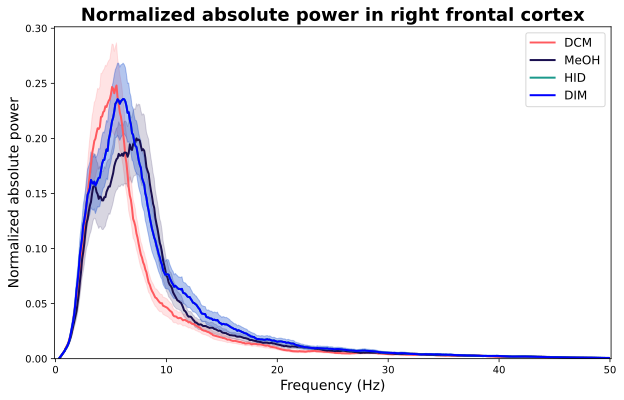

In [103]:
c = ["#ff595e", "#190e4f", "#1b998b", "blue"]
labels = ["DCM", "MeOH", "HID", "DIM"]
titulo = "Normalized absolute power in right frontal cortex"
formato = "pdf"
factor = factor_error(1, errores, errores_suavizados)

grafica_potencia_relativa_suavizado(promedios_suavizados, factor, 
                                    titulo, labels, c, guardar_grafica=1, formato=formato, alpha=0.17)